In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

## Load Data

In [5]:
import boto3
from io import BytesIO
from fastparquet import ParquetFile

s3 = boto3.client("s3")
response = s3.list_objects_v2(Bucket='covid-19-prj', Prefix ='raw/wcota/')
all_objects = [item.get('Key') for item in response.get('Contents')][1:]

def read_parquet_from_s3(keyName):
    obj = s3.get_object(Bucket='covid-19-prj', Key=keyName)
    df = obj['Body'].read()
    return ParquetFile(BytesIO(df)).to_pandas()

dataframes = [read_parquet_from_s3(key_name) for key_name in all_objects]
df = pd.concat(dataframes, axis=0)

## Overview

In [6]:
df.head()

,date,country,state,city,ibgeID,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases
index,,,,,,,,,,,,
0,2020-02-25,Brazil,SP,São Paulo/SP,3550308,0,0,1,1,0.0,0.00816,0.0
2,2020-02-26,Brazil,SP,São Paulo/SP,3550308,0,0,0,1,0.0,0.00816,0.0
4,2020-02-27,Brazil,SP,São Paulo/SP,3550308,0,0,0,1,0.0,0.00816,0.0
6,2020-02-28,Brazil,SP,São Paulo/SP,3550308,0,0,1,2,0.0,0.01632,0.0
8,2020-02-29,Brazil,SP,São Paulo/SP,3550308,0,0,0,2,0.0,0.01632,0.0


In [7]:
df.describe()

,ibgeID,newDeaths,deaths,newCases,totalCases,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases
count,5.532000e+04,55320.000000,55320.000000,55320.000000,55320.000000,55320.000000,55320.000000,55320.000000
mean,3.176612e+06,0.155423,2.029411,2.295589,31.447578,1.201815,18.197219,0.076833
std,1.020548e+06,2.065477,28.928783,26.384129,362.381671,3.510489,37.088624,0.207094
min,1.100000e+01,-31.000000,0.000000,-1192.000000,0.000000,0.000000,0.000000,0.000000
25%,2.503001e+06,0.000000,0.000000,0.000000,1.000000,0.000000,3.532560,0.000000
50%,3.200607e+06,0.000000,0.000000,0.000000,2.000000,0.000000,8.216930,0.000000
75%,4.109302e+06,0.000000,1.000000,1.000000,7.000000,0.364720,18.830768,0.029242
max,5.300108e+06,149.000000,1910.000000,2047.000000,23187.000000,62.053990,953.615410,1.000000


In [8]:
df.dtypes

date                                object
country                             object
state                               object
city                                object
ibgeID                               int64
newDeaths                            int64
deaths                               int64
newCases                             int64
totalCases                           int64
deaths_per_100k_inhabitants        float64
totalCases_per_100k_inhabitants    float64
deaths_by_totalCases               float64
dtype: object

In [9]:
# Take a look at the date type
np.array([isinstance(x, str) for x in df.date]).all()

True

## EDA

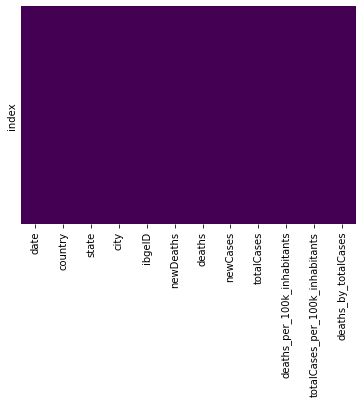

In [10]:
# Missing values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [11]:
# For more details
display(df.isnull().sum().sort_values(ascending=False))

deaths_by_totalCases               0
totalCases_per_100k_inhabitants    0
deaths_per_100k_inhabitants        0
totalCases                         0
newCases                           0
deaths                             0
newDeaths                          0
ibgeID                             0
city                               0
state                              0
country                            0
date                               0
dtype: int64

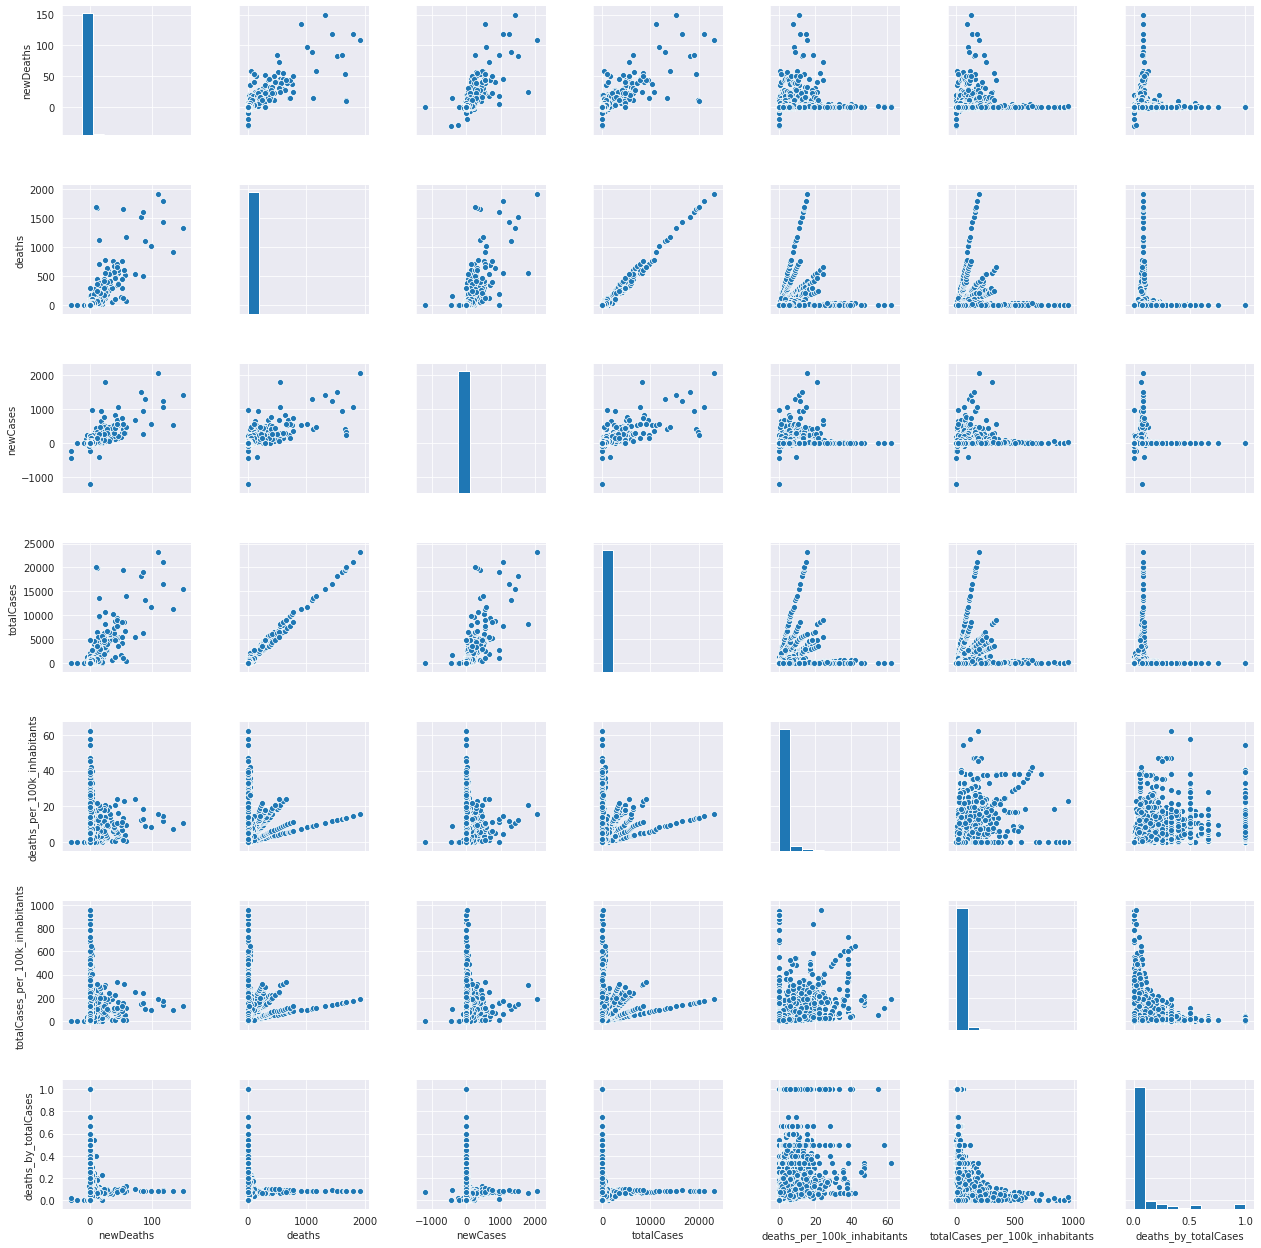

In [13]:
sns.set_style("darkgrid")
sns.pairplot(df[df.columns[-7:]])

In [17]:
# Unify the date column format
df['date'] = pd.to_datetime(df.date).dt.date
# Sort dates
df = df.sort_values('date')
cumulated = df.groupby('date').agg({'newCases': 'sum',
                                    'newDeaths': 'sum',
                                    'totalCases': 'sum', 
                                    'deaths': 'sum', 
                                    'totalCases_per_100k_inhabitants': 'sum'}).reset_index()

In [18]:
cumulated.describe()

,newCases,newDeaths,totalCases,deaths,totalCases_per_100k_inhabitants
count,72.000000,72.000000,72.000000,72.000000,72.000000
mean,1763.777778,119.416667,24162.222222,1559.263889,13981.530241
std,2290.256842,160.898687,33703.870370,2333.428699,22539.981606
min,0.000000,0.000000,1.000000,0.000000,0.008160
25%,43.500000,0.000000,133.000000,0.000000,63.110678
50%,942.000000,39.000000,6377.500000,223.000000,1970.895670
75%,2742.750000,202.000000,37680.500000,2404.000000,18316.415620
max,10377.000000,621.000000,126790.000000,8593.000000,92090.797800


/home/ubuntu/anaconda/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


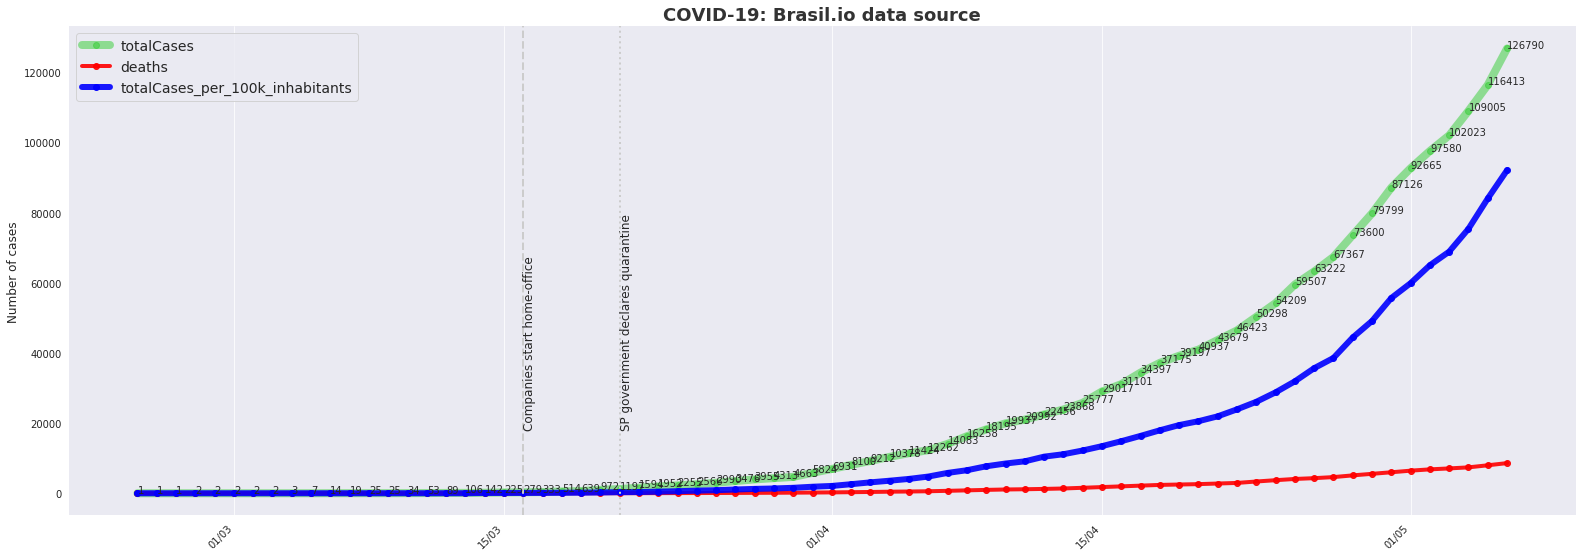

In [19]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
%matplotlib inline

fig, ax = plt.subplots(figsize=(27, 9))

plt.plot(cumulated['date'], cumulated['totalCases'], color='limegreen', linewidth=8, alpha=0.5, marker='o')
plt.plot(cumulated['date'], cumulated['deaths'], color='red', linewidth=4, alpha=0.9, marker='o')
plt.plot(cumulated['date'], cumulated['totalCases_per_100k_inhabitants'], color='blue', linewidth=6, alpha=0.9, marker='o')


[ax.annotate('%s' % y, xy=(x,y+100), fontsize=10) for x,y in zip(cumulated['date'], cumulated['totalCases'])]

plt.xticks(rotation=45, ha='right')
plt.title('COVID-19: Brasil.io data source', fontsize=18, fontweight='bold', color='#333333')

plt.ylabel('Number of cases', fontsize=12)
plt.xlabel(None)

plt.axvline('2020-03-16', 0, 1200, c='#CCCCCC', linestyle='--', linewidth=2, alpha=1)
ax.annotate('Companies start home-office', xy=('2020-03-16',19000), fontsize=12, rotation=90)
plt.axvline('2020-03-21', 0, 1200, c='#CCCCCC', linestyle='dotted', linewidth=2, alpha=1)
ax.annotate('SP government declares quarantine', xy=('2020-03-21',19000), fontsize=12, rotation=90)

plt.legend(loc=2, labels=['totalCases','deaths', 'totalCases_per_100k_inhabitants'], fontsize=14)

plt.grid(which='major', axis='y')
[ax.spines[side].set_visible(False) for side in ['left','right','top']]
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
plt.show();

In [21]:
np.all(np.diff(cumulated.totalCases) >= 0)

True

In [22]:
np.all(np.diff(cumulated.deaths) >= 0)

True

*Awesome*

### Confirmed cases distribution

[Text(0.5, 0, '')]

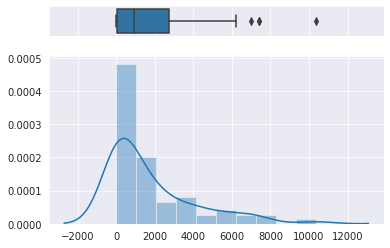

In [24]:
confirmed_cases = cumulated.newCases.values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(confirmed_cases, ax=ax_box)
sns.distplot(confirmed_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

### Death cases distribution

[Text(0.5, 0, '')]

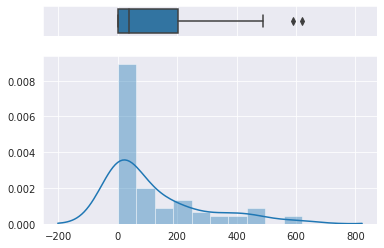

In [25]:
deaths_cases = cumulated.newDeaths.values

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.set_style("darkgrid")
sns.boxplot(deaths_cases, ax=ax_box)
sns.distplot(deaths_cases, bins=10, ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

In [16]:
# Let's take a look at the number of cities per date
#y = df.groupby('date').agg({'city': (lambda x: x.nunique())})
#sns.distplot(y.city, bins=10)